In [1]:
import os
import json

import supervisely as sly
from tqdm import tqdm

/home/nata-brain/miniconda3/envs/yolo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input = "./skin-cancer_-ham10000-DatasetNinja"
output = "./results"
os.makedirs(output, exist_ok=True)

In [4]:
# Creating Supervisely project from local directory.
project = sly.Project(input, sly.OpenMode.READ)
print("Opened project: ", project.name)
print("Number of images in project:", project.total_items)

# Showing annotations tags and classes.
print(project.meta)

# Iterating over classes in project, showing their names, geometry types and colors.
for obj_class in project.meta.obj_classes:
    print(
        f"Class '{obj_class.name}': geometry='{obj_class.geometry_type}', color='{obj_class.color}'",
    )

# Iterating over tags in project, showing their names and colors.
for tag in project.meta.tag_metas:
    print(f"Tag '{tag.name}': color='{tag.color}'")

print("Number of datasets (aka folders) in project:", len(project.datasets))

progress = tqdm(project.datasets, desc="Processing datasets")
for dataset in project.datasets:
    # Iterating over images in dataset, using the paths to the images and annotations.
    for item_name, image_path, ann_path in dataset.items():
        print(f"Item '{item_name}': image='{image_path}', ann='{ann_path}'")

        ann_json = json.load(open(ann_path))
        ann = sly.Annotation.from_json(ann_json, project.meta)

        img = sly.image.read(image_path)  # rgb - order

        for label in ann.labels:
            # Drawing each label on the image.
            label.draw(img)

        res_image_path = os.path.join(output, item_name)
        sly.image.write(res_image_path, img)

        # Or alternatively draw annotation (all labels at once) preview with
        # ann.draw_pretty(img, output_path=res_image_path)

        progress.update(1)

Opened project:  skin-cancer_-ham10000-DatasetNinja
Number of images in project: 10015
ProjectMeta:
Object Classes
+-------------------------------+--------+----------------+--------+
|              Name             | Shape  |     Color      | Hotkey |
+-------------------------------+--------+----------------+--------+
|       actinic keratoses       | Bitmap | [15, 138, 123] |        |
|      basal cell carcinoma     | Bitmap | [15, 50, 138]  |        |
| benign keratosis-like lesions | Bitmap | [138, 49, 15]  |        |
|         dermatofibroma        | Bitmap | [15, 138, 59]  |        |
|        melanocytic nevi       | Bitmap | [95, 138, 15]  |        |
|            melanoma           | Bitmap | [138, 135, 15] |        |
|        vascular lesions       | Bitmap | [138, 82, 15]  |        |
+-------------------------------+--------+----------------+--------+
Tags
+------+------------+-----------------+--------+---------------+--------------------+
| Name | Value type | Possible valu

Processing datasets:   0%|          | 0/1 [00:00<?, ?it/s]

Item 'ISIC_0027724.jpg': image='./skin-cancer_-ham10000-DatasetNinja/ds/img/ISIC_0027724.jpg', ann='./skin-cancer_-ham10000-DatasetNinja/ds/ann/ISIC_0027724.jpg.json'


Processing datasets: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Item 'ISIC_0033598.jpg': image='./skin-cancer_-ham10000-DatasetNinja/ds/img/ISIC_0033598.jpg', ann='./skin-cancer_-ham10000-DatasetNinja/ds/ann/ISIC_0033598.jpg.json'
Item 'ISIC_0032119.jpg': image='./skin-cancer_-ham10000-DatasetNinja/ds/img/ISIC_0032119.jpg', ann='./skin-cancer_-ham10000-DatasetNinja/ds/ann/ISIC_0032119.jpg.json'
Item 'ISIC_0029653.jpg': image='./skin-cancer_-ham10000-DatasetNinja/ds/img/ISIC_0029653.jpg', ann='./skin-cancer_-ham10000-DatasetNinja/ds/ann/ISIC_0029653.jpg.json'
Item 'ISIC_0027807.jpg': image='./skin-cancer_-ham10000-DatasetNinja/ds/img/ISIC_0027807.jpg', ann='./skin-cancer_-ham10000-DatasetNinja/ds/ann/ISIC_0027807.jpg.json'
Item 'ISIC_0029262.jpg': image='./skin-cancer_-ham10000-DatasetNinja/ds/img/ISIC_0029262.jpg', ann='./skin-cancer_-ham10000-DatasetNinja/ds/ann/ISIC_0029262.jpg.json'
Item 'ISIC_0025436.jpg': image='./skin-cancer_-ham10000-DatasetNinja/ds/img/ISIC_0025436.jpg', ann='./skin-cancer_-ham10000-DatasetNinja/ds/ann/ISIC_0025436.jpg.json

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("surajghuwalewala/ham1000-segmentation-and-classification")

print("Path to dataset files:", path)

Path to dataset files: /home/nata-brain/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2


In [2]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm


## Encoding

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)
    
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

## Decoding

In [5]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

## U-Net Architecture

In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

### Testing

In [7]:
input_image = torch.rand((1,3,512,512))
model = UNet(3,10)
output = model(input_image)
print(output.size())

torch.Size([1, 10, 512, 512])


In [8]:
class SkinCancerDataset(Dataset):
    def __init__(self, root_path, limit=None):
        self.root_path = root_path
        self.limit = limit
        self.images = sorted([root_path + "/images/" + i for i in os.listdir(root_path + "/images/")])[:self.limit]
        self.masks = sorted([root_path + "/masks/" + i for i in os.listdir(root_path + "/masks/")])[:self.limit]

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()])
        
        if self.limit is None:
            self.limit = len(self.images)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask)

    def __len__(self):
        return min(len(self.images), self.limit)

In [9]:
DATASET_DIR =  "./"
WORKING_DIR = "./ham1000-segmentation-and-classification/versions/2/"

In [10]:
train_dataset = SkinCancerDataset(WORKING_DIR)
generator = torch.Generator().manual_seed(25)

### Split to train, test and validation

80% for training, 10% for testing, and 10% for validation.

In [11]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)
test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5], generator=generator)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    num_workers = torch.cuda.device_count() * 4
    
print(device)

cuda


AdamW optimizer and the BCEWithLogitsLoss loss criterion

In [13]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 8

train_dataloader = DataLoader(dataset=train_dataset,
                              num_workers=num_workers, pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

model = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

### Evaluating Segmentation Performance with the DICE Metric
DICE score = 2 * |A ∩ B| / (|A| + |B|)

Dice score = 2 * (number of common elements) / (number of elements in set A + number of elements in set B

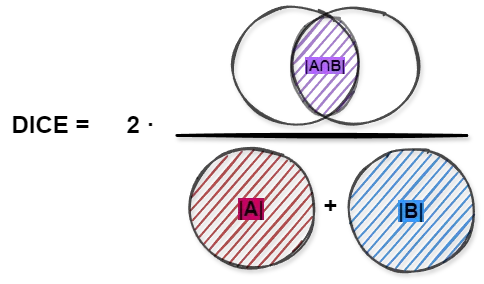

In [14]:
def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    return dice

In [15]:
torch.cuda.empty_cache()


## Training the model

In [ ]:
EPOCHS = 10

train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0
    
    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        
        dc = dice_coefficient(y_pred, mask)
        loss = criterion(y_pred, mask)
        
        train_running_loss += loss.item()
        train_running_dc += dc.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)
    
    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0
    
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)
            dc = dice_coefficient(y_pred, mask)
            
            val_running_loss += loss.item()
            val_running_dc += dc.item()

        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)
    
    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    print("-" * 30)

# Saving the model
torch.save(model.state_dict(), './models/skin_cancer_v1.pth')

  0%|          | 0/1002 [00:00<?, ?it/s]